In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
from torch.utils.data import DataLoader

from specseg.core.dataset import SignalAnalysisDataset, SignalMLDataset
from specseg.core.transform import Transform
from transform_baseline import HFLabel
from transform_baseline import HFFeature as CrossFeature
from specseg import helpers
from specseg.core import visualize as vis

from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize
from omegaconf import OmegaConf

from models import BaselineModel

sns.set_style("dark")
plt.style.use('dark_background')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
state_dict = torch.load(
    "../../output/co2cross/best_model.pth", 
    weights_only=True, 
    map_location=device
    )
model = BaselineModel()
model.load_state_dict(state_dict)
model.eval()

print("Model Ready")

Model Ready


In [4]:
config_name = "baseline"
if GlobalHydra.instance().is_initialized(): GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config", job_name="co2_modes")
cfg = compose(config_name=config_name)
cfg = OmegaConf.to_container(cfg, resolve=True)

root_dir = cfg['dataset_cfg']['root_dir']
train_shots = helpers.get_shots(root_dir, 'train')
val_shots = helpers.get_shots(root_dir, 'valid')

cross_inputs = ['r0', 'v1', 'v2', 'v3']
labels = ['lfm','bae','eae', 'rsae', 'tae']

transform = Transform(
    CrossFeature,
    HFLabel,
    cfg=cfg['transform_cfg'],
)

dataset = SignalMLDataset(
    stage='train',
    inputs=cross_inputs,
    labels=labels,
    shots=train_shots,
    transform=transform,
    cfg=cfg['dataset_cfg'],
)
dataset.setup()
# dataset.transform.transform_label.cfg['nframes'] = 25

Transforming Feature and Label
Stage: Train
Batch Inputs: True
Number windows per shot: 110
Number of inputs per shot: 4
Number of shots: 167
Total length of dataset: 18370


Transform successfully applied to the dataset.
Dataset setup complete


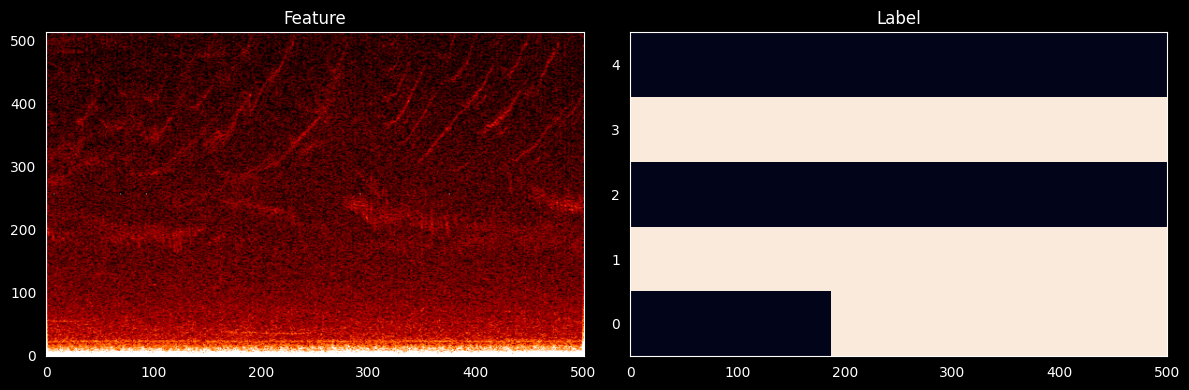

In [5]:
x = dataset[156*110+55]
vis.imshow((x['features'],x['labels']))

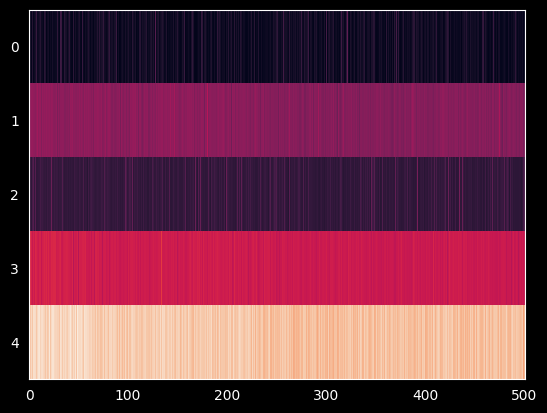

In [6]:
pred = model(x['features'].unsqueeze(0).to(device))
pred = torch.sigmoid(pred)
pred = pred.squeeze(0).cpu().detach().numpy()
plt.imshow(pred, aspect='auto', interpolation='none')
plt.show()

In [21]:
import pandas as pd
datpath = Path(dataset.cfg['root_dir']) / 'train' / '170000.parquet'
data = pd.read_parquet(datpath).index.values
tstart = data[0] / np.timedelta64(1, 'ms')
tend = data[-1] / np.timedelta64(1, 'ms')
print(tstart, tend)

0.0 1499999.0


In [22]:
labels = [
    "lfm",
    "bae",
    "eae",
    "rsae",
    "tae",
]

In [43]:
x = dataset[1201*10+1]['features']
x = x.unsqueeze(0)

with torch.no_grad():
    y = model(x.to(device))
    y = torch.sigmoid(y)

In [214]:
dataset.on_off = False

In [215]:
loader = DataLoader(dataset, batch_size=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8416406..11.4923115].


Saved /scratch/gpfs/nc1514/specseg/output/co2cross/inference/1201


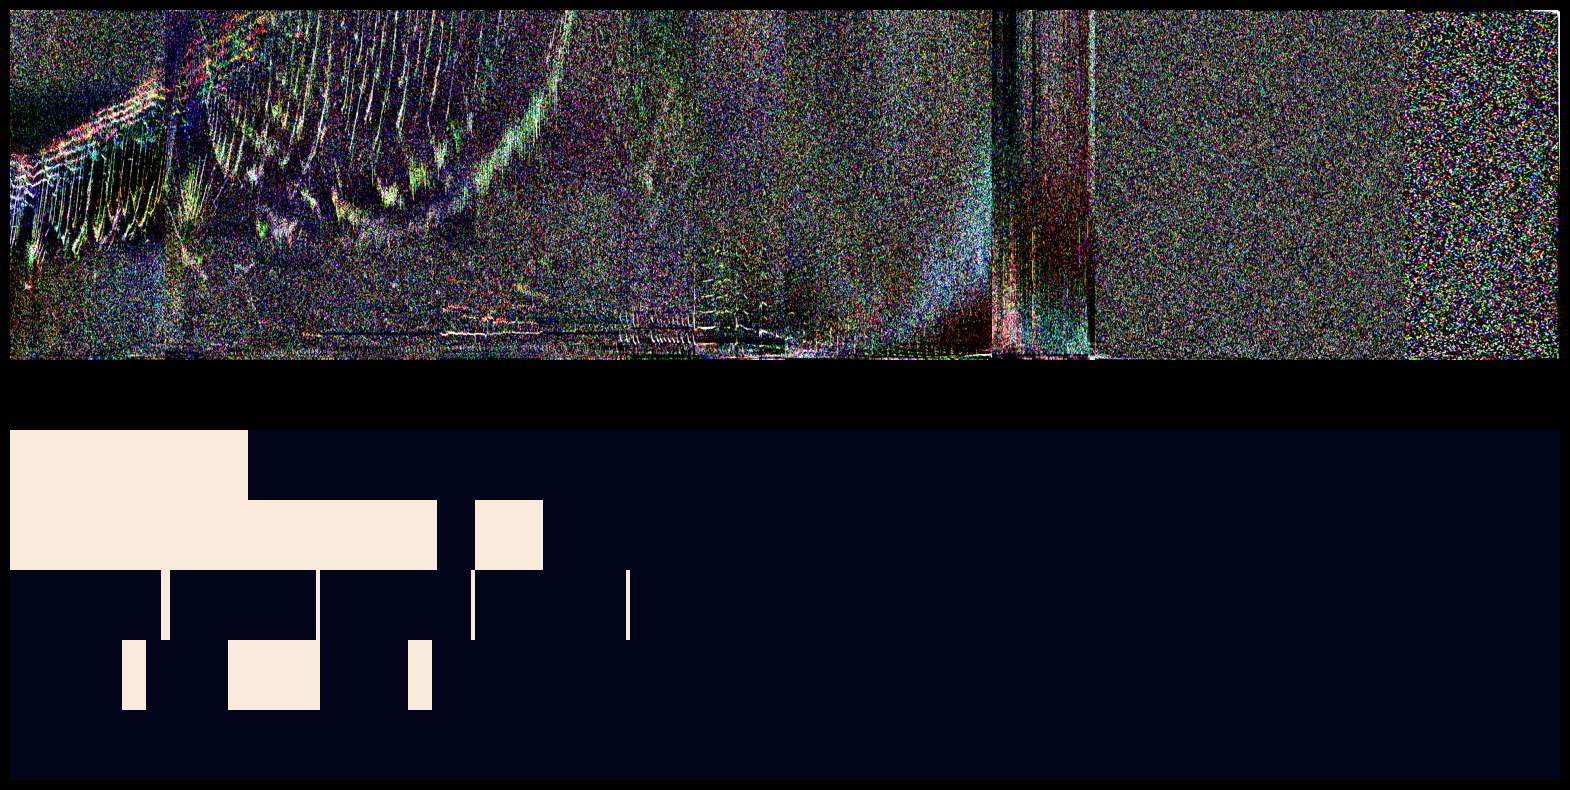

In [ ]:
B, H, W = 10, 5, 150
result_dir_root = Path('/scratch/gpfs/nc1514/specseg/output/co2cross/inference')
windows_per_shot = dataset.cfg['window_count']
for idx, data in enumerate(loader):
    x = data['features']
    shot_num = dataset.shots[idx]
    
    # idx = 1201
    # x = []
    # for i in range(10):
    #     xtemp = dataset[idx*10+i]['features']
    #     x.append(xtemp)
    # x = torch.stack(x, dim=0)
    # x = x.to(device)
    
    with torch.no_grad():
        result = model(x.to(device))
        result = torch.sigmoid(result)
    result2 = result.permute(1,0,2).reshape(H, B * W)
    result2 = result2.cpu().numpy()
    result_dir = result_dir_root / str(shot_num)
    np.save(result_dir, result2)
    
    B, C, H, W = x.shape
    stacked = x.permute(1, 2, 0, 3).reshape(C, H, B * W)
    img = stacked.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.imshow(img, aspect='auto', cmap='magma', origin='lower')
    plt.axis('off')
    plt.subplot(2, 1, 2)
    plt.imshow(result2 > 0.4, aspect='auto', origin='lower', interpolation='none')
    plt.axis('off')
    im_dir = result_dir.with_suffix('.png')
    plt.savefig(im_dir)
    print(f"Saved {result_dir}", flush=True)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5497363..9.012334].


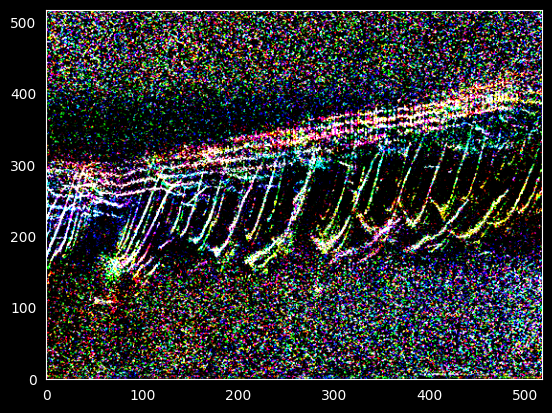

In [232]:
plt.imshow(x[0].permute(1,2,0).cpu().numpy(), aspect='auto', cmap='magma', origin='lower')
plt.show()

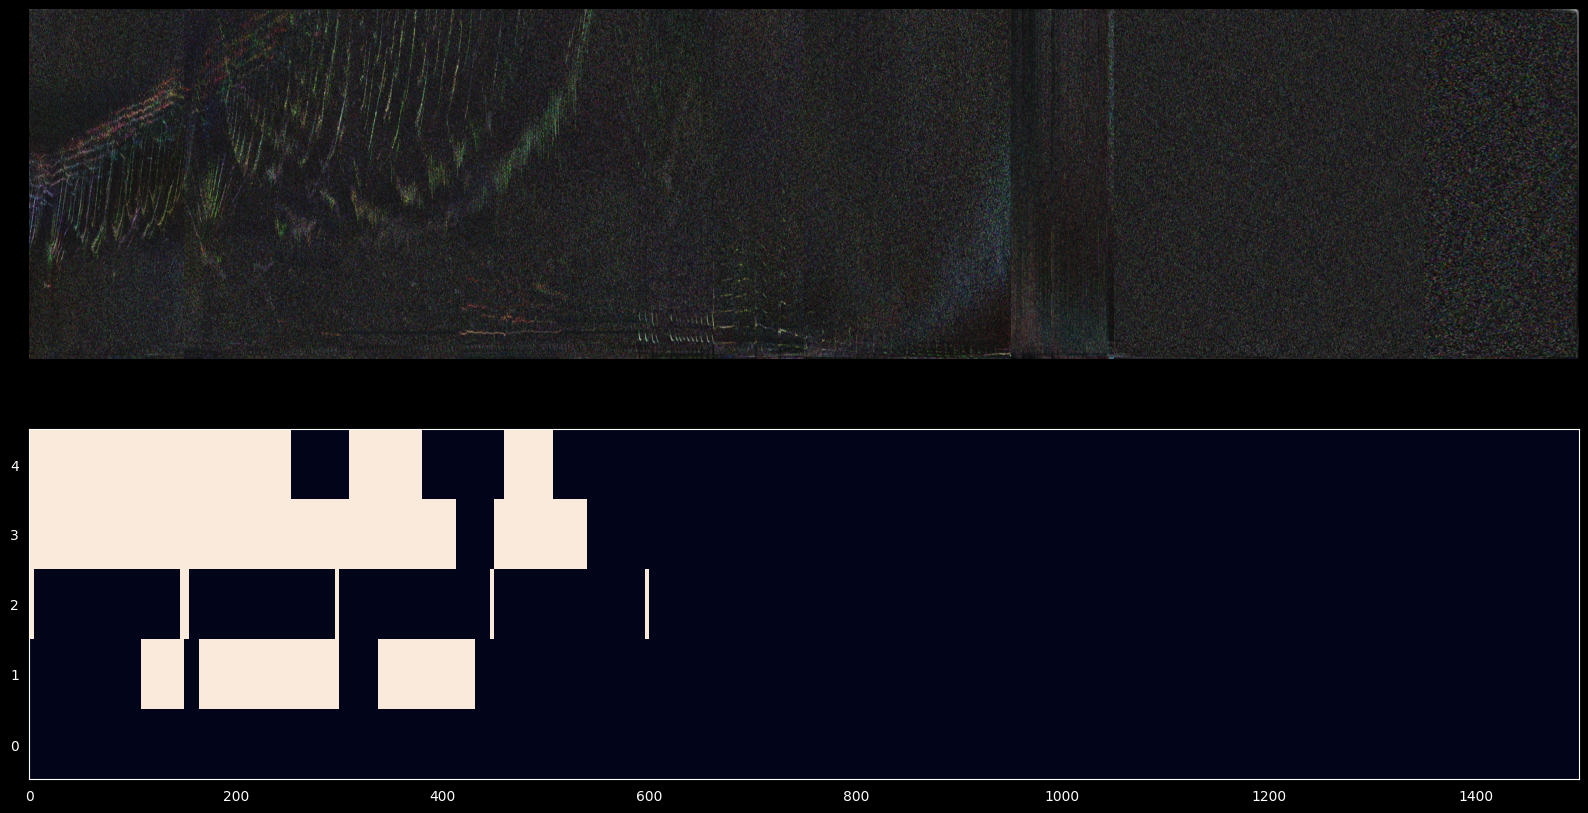

In [235]:
B, C, H, W = x.shape
stacked = x.permute(1, 2, 0, 3).reshape(C, H, B * W)
img = stacked.permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(img, aspect='auto', cmap='magma', origin='lower')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(result2 > 0.4, aspect='auto', origin='lower', interpolation='none')
plt.show()